In [1]:
import time

import keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import ParameterGrid

In [2]:
X_train = np.load('Data/X_train.npy')  # Load your preprocessed training data
y_train = np.load('Data/y_train.npy')
X_val = np.load('Data/X_val.npy')  # Load your validation data
y_val = np.load('Data/y_val.npy')
X_test = np.load('Data/X_test.npy')  # Load your test data
y_test = np.load('Data/y_test.npy')

In [3]:
# Define the parameter grid
param_grid = {
    "filters": [32, 64],
    "kernel_size": [3, 5],
    "dropout_rate": [0.2, 0.4],
    "batch_size": [16, 32],
    "learning_rate": [0.001, 0.0005]
}

In [4]:
# Create a list of all parameter combinations
param_combinations = list(ParameterGrid(param_grid))
print(f"Total combinations to try: {len(param_combinations)}")

Total combinations to try: 32


In [5]:
# Limit the number of combinations to try
max_combinations = 20
param_combinations = param_combinations[:max_combinations]

# Results storage
results = []

In [6]:
num_classes = len(np.unique(y_train))

def make_model(input_shape, filters, kernel_size, dropout_rate):
    input_layer = keras.layers.Input(input_shape)
    x = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, padding="same")(input_layer)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.Dropout(dropout_rate)(x)

    x = keras.layers.GlobalAveragePooling1D()(x)
    output_layer = keras.layers.Dense(num_classes, activation="softmax")(x)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

In [7]:
best_val_acc = 0
best_model_path = "Saved Models/best_cnn.keras"
best_params = None
best_history = None

for params in param_combinations:
    print(f"\nTraining with parameters: {params}")
    start_time = time.time()

    # Create model
    model = make_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        filters=params["filters"],
        kernel_size=params["kernel_size"],
        dropout_rate=params["dropout_rate"]
    )

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=params["learning_rate"])
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"]
    )

    # Train the model (fewer epochs for grid search)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=8,  # Use fewer epochs for speed
        batch_size=params["batch_size"],
        verbose=1
    )

    # Evaluate on the validation set
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    elapsed_time = time.time() - start_time

    # Check if this is the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = params
        best_history = history
        print(f"New best model found with validation accuracy: {val_acc:.4f}")
        model.save(best_model_path)  # Save the best model

    # Store the results
    results.append({
        "params": params,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "time": elapsed_time
    })

    print(f"Validation Accuracy: {val_acc:.4f} | Time: {elapsed_time:.2f}s")


Training with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'filters': 32, 'kernel_size': 3, 'learning_rate': 0.001}
Epoch 1/8
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.6395 - sparse_categorical_accuracy: 0.6212 - val_loss: 0.4708 - val_sparse_categorical_accuracy: 0.7627
Epoch 2/8
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4575 - sparse_categorical_accuracy: 0.8125 - val_loss: 0.3975 - val_sparse_categorical_accuracy: 0.8732
Epoch 3/8
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4348 - sparse_categorical_accuracy: 0.8347 - val_loss: 0.3857 - val_sparse_categorical_accuracy: 0.8655
Epoch 4/8
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.4193 - sparse_categorical_accuracy: 0.8143 - val_loss: 0.3847 - val_sparse_categorical_accuracy: 0.8540
Epoch 5/8
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3929 - sparse_categorical_accuracy: 0.8479 - val_loss: 0.3764 - val_sparse_categorical_accuracy: 0.8703
Epoch 6/8
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/

In [8]:
print("\nBest Parameters:")
print(best_params)


Best Parameters:
{'batch_size': 16, 'dropout_rate': 0.2, 'filters': 64, 'kernel_size': 5, 'learning_rate': 0.0005}


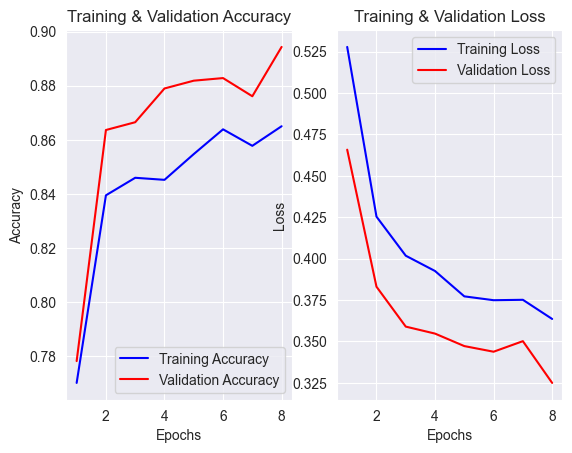

In [9]:
# Extract values
epochs = range(1, len(best_history.history["loss"]) + 1)

# Plot training & validation accuracy
plt.figure()

plt.subplot(1, 2, 1)
plt.plot(epochs, best_history.history["sparse_categorical_accuracy"], "b", label="Training Accuracy")
plt.plot(epochs, best_history.history["val_sparse_categorical_accuracy"], "r", label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, best_history.history["loss"], "b", label="Training Loss")
plt.plot(epochs, best_history.history["val_loss"], "r", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.show()

In [10]:
# Load the saved best model
best_model = keras.models.load_model(best_model_path)

# Generate predictions on the test set
y_pred = np.argmax(best_model.predict(X_test), axis=-1)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       539
           1       0.81      0.93      0.87       298

    accuracy                           0.90       837
   macro avg       0.88      0.90      0.89       837
weighted avg       0.90      0.90      0.90       837

